<a href="https://colab.research.google.com/github/hakimmurphy/time_series_corporacion/blob/main/Corporacion_Favorita_Grocery_Sales_Forecasting_Guayas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Corporación Favorita Grocery Sales Forecasting - Guayas

1. Check for missing values
2. Check for outliers
  1. Handle negative sales
3. Zero sales - include in data frame
4. Feature Engineering
  1. Time-based features
  2. Rolling / Expanding window
5. EDA
  1. Visual EDA
  2. Analyse monthly sales
  3. Analyse holiday impact on sales
  4. and more

# Import the Data

In [ ]:
from google.colab import files

# This will prompt you to upload the kaggle.json file
files.upload()

In [7]:
!mkdir -p ~/.kaggle

In [8]:
!mv kaggle.json ~/.kaggle/

In [9]:
# Set the correct permissions
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
# List the available datasets in the competition
!kaggle competitions files -c favorita-grocery-sales-forecasting

name                            size  creationDate                
------------------------  ----------  --------------------------  
holidays_events.csv.7z          1898  2018-06-20 06:10:54.148000  
items.csv.7z                   14315  2018-06-20 06:10:54.148000  
oil.csv.7z                      3762  2018-06-20 06:10:54.148000  
sample_submission.csv.7z      666528  2018-06-20 06:10:54.148000  
stores.csv.7z                    648  2018-06-20 06:10:54.148000  
test.csv.7z                  4885065  2018-06-20 06:10:54.148000  
train.csv.7z               474092593  2018-06-20 06:10:54.148000  
transactions.csv.7z           219499  2018-06-20 06:10:54.148000  


In [11]:
# Download the dataset
!kaggle competitions download -c favorita-grocery-sales-forecasting

favorita-grocery-sales-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!mkdir -p /content/drive/MyDrive/retail_kaggle_data

In [14]:
!cp favorita-grocery-sales-forecasting.zip /content/drive/MyDrive/retail_kaggle_data/

In [ ]:
# Unzip the downloaded dataset
!unzip /content/drive/MyDrive/retail_kaggle_data/favorita-grocery-sales-forecasting.zip

In [ ]:
!apt-get install -y p7zip-full

In [ ]:
!7z e train.csv.7z
!7z e stores.csv.7z
!7z e items.csv.7z
!7z e holidays_events.csv.7z
!7z e oil.csv.7z
!7z e transactions.csv.7z

# Import Libraries

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrames

In [19]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')

# Note: train file is very large.
# To make sure we fit RAM avaible on Google-Colab, we will load only part of the file
df_train = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', nrows=2e6)

In [20]:
print(df_train['date'].min(), df_train['date'].max())

2013-01-01 2013-02-19


In [21]:
print(df_train.columns)

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion'], dtype='object')


# Filtering Guayas state and creating Train DataFrame

In [22]:
# Select list of stores located in the 'Pichincha' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

<ipython-input-22-83b2f151a3bd>:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):


In [23]:
df_train.shape

(22941656, 6)

In [24]:
print(df_train.columns)

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion'], dtype='object')


# Plotting the top 3 families

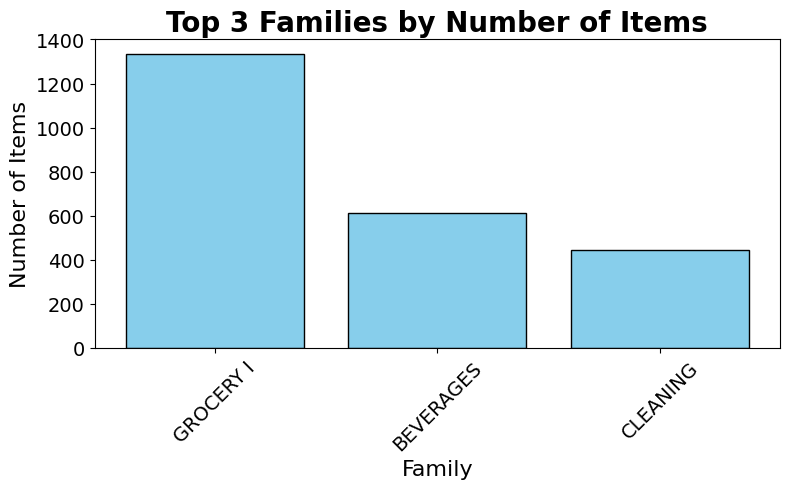

In [25]:
# Plotting the number of items per family (for top 3 families only)
# Compute the number of items per family and select the top 3 families
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)  # Keep only the top 3 families

# Plot the top 3 families
plt.figure(figsize=(8, 5))
plt.bar(top_3_families['Family'], top_3_families['Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 3 Families by Number of Items", fontsize=20, fontweight='bold')
plt.xlabel("Family", fontsize=16)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()


In [26]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,18789,2013-01-02,24,103665,6.0,NaN
1,18790,2013-01-02,24,105574,12.0,NaN
2,18791,2013-01-02,24,105575,2.0,NaN
3,18792,2013-01-02,24,105577,1.0,NaN
4,18793,2013-01-02,24,105693,7.0,NaN


In [27]:
item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()
df_train = df_train[df_train['item_nbr'].isin(item_ids)]

In [28]:
df_train.shape

(14745768, 6)

# Checking and filling missing values

In [29]:
# Checking missing values
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,2747275


In [30]:
# Focusing on missing values in the 'onpromotion' column
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)
df_train['onpromotion'] = df_train['onpromotion'].astype(int)
df_train.head()

<ipython-input-30-c718cf7230a7>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1,18790,2013-01-02,24,105574,12.0,0
2,18791,2013-01-02,24,105575,2.0,0
3,18792,2013-01-02,24,105577,1.0,0
4,18793,2013-01-02,24,105693,7.0,0
5,18794,2013-01-02,24,105737,17.0,0


In [31]:
df_train['onpromotion'].value_counts()

,count
onpromotion,
0,14066471
1,679297


In [32]:
# Converting boolean values to 0 and 1
# df_train['onpromotion'] = df_train['onpromotion'].astype(int)  # Convert True/False to 1/0
# df_train['onpromotion'] = df_train['onpromotion'].apply(lambda x: 1 if x == 0 else 0)  # Swap 1 and 0

# Checking for Negative sales

In [33]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

# Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

negative_sales.head()  # Viewing negative sales for analysis

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
18589,106658,2013-01-04,34,586824,-2.0,0
54236,309805,2013-01-09,35,1079215,-8.0,0
64452,382905,2013-01-11,27,1097187,-20.0,0
96414,564108,2013-01-15,51,627885,-36.0,0
132903,787522,2013-01-21,24,211205,-5.0,0


# Checking Outliers

In [34]:
# Function to calculate Z-score for each group (store-item combination)
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score (avoiding division by zero for standard deviation)
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group

# Apply the Z-score calculation to each store-item group without resetting the index
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped.reset_index(drop=True, inplace=True)

# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

# Print summary
print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

Number of outliers detected: 48485


<ipython-input-34-5b5aa677d807>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
188,15666702,2013-12-18,24,96995,14.0,0,7.946399
286,59775862,2015-10-20,24,99197,14.0,0,5.822016
289,60322807,2015-10-26,24,99197,19.0,0,8.276173
721,15717753,2013-12-19,24,103520,27.0,0,6.642670
770,18886543,2014-02-13,24,103520,22.0,0,5.154400


# Date Feature Engineering

In [35]:
# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Get full date range
full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})

# Create a DataFrame with all (store, item, date) combinations
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates()
all_combinations = store_item_combinations.merge(full_date_range, how='cross')

# Merge with original data to fill missing dates
df_filled = all_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left')

# Fill missing sales values with 0
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)

# Check the first few rows
df_filled.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0


In [36]:
# Convert date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Creating new time-based features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek

# Rolling Average

In [37]:
# Calculating rolling average of unit_sales
df_train['unit_sales_7d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())

In [38]:
df_train.head(10)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
1,18790,2013-01-02,24,105574,12.0,0,2013,1,2,2,NaN
2,18791,2013-01-02,24,105575,2.0,0,2013,1,2,2,NaN
3,18792,2013-01-02,24,105577,1.0,0,2013,1,2,2,NaN
4,18793,2013-01-02,24,105693,7.0,0,2013,1,2,2,NaN
5,18794,2013-01-02,24,105737,17.0,0,2013,1,2,2,NaN
6,18795,2013-01-02,24,105857,1.0,0,2013,1,2,2,NaN
7,18796,2013-01-02,24,106716,3.0,0,2013,1,2,2,NaN
10,18799,2013-01-02,24,108786,3.0,0,2013,1,2,2,NaN
11,18800,2013-01-02,24,108797,2.0,0,2013,1,2,2,NaN
13,18802,2013-01-02,24,108862,3.0,0,2013,1,2,2,NaN


# Plots

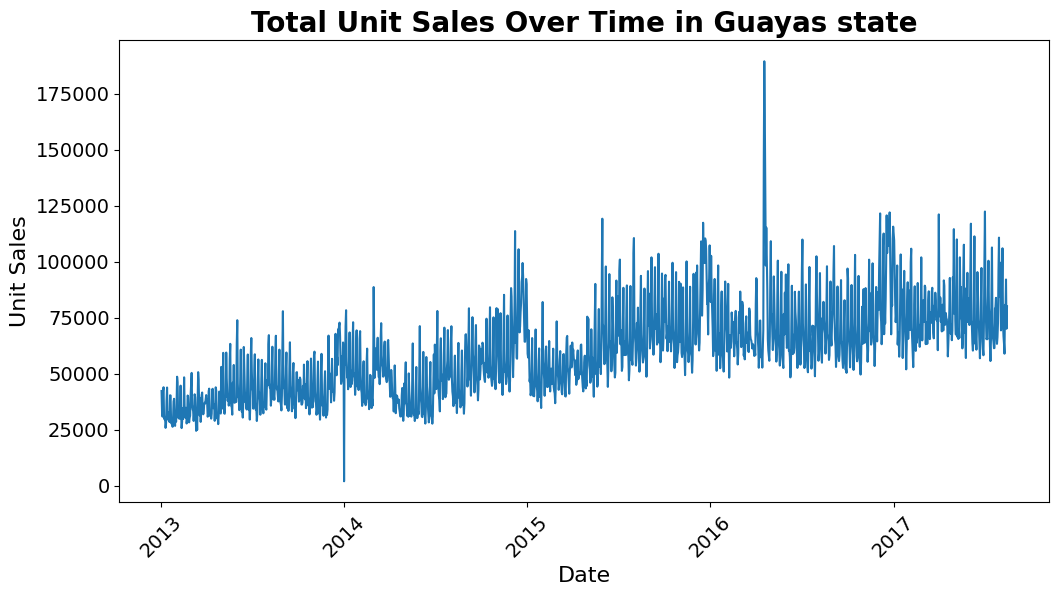

In [39]:
# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

In [40]:
# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

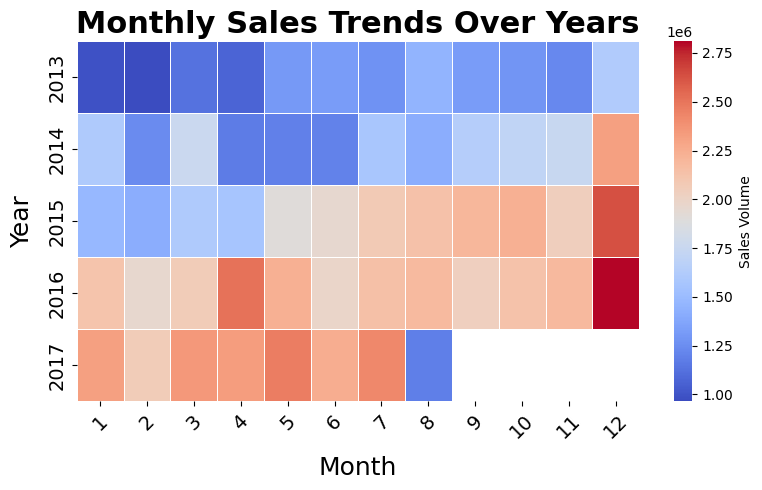

In [41]:
# Plotting heatmap of sales by year and month
plt.figure(figsize=(8, 5))  # Increase figure size for better visibility
sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

In [42]:
# Convert date column to datetime
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
print("Holidays range: from",df_holidays_events['date'].dt.date.min(),"till",df_holidays_events['date'].dt.date.max())

Holidays range: from 2012-03-02 till 2017-12-26


In [43]:
# Merging df_train data with holidays
df_train_holiday = pd.merge(df_train, df_holidays_events, on='date', how='left')

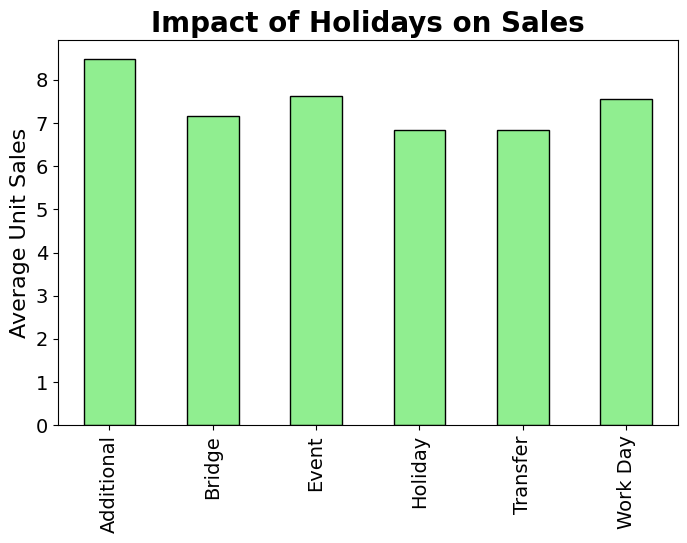

In [44]:
# Aggregating sales by holiday and non-holiday
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

# Plotting holiday impact
plt.figure(figsize=(8,5))
holiday_sales.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Impact of Holidays on Sales', fontsize=20, fontweight='bold')
plt.ylabel('Average Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [45]:
# Merging df_train with items to get perishable data
df_train_items = pd.merge(df_train, df_items, on='item_nbr', how='left')
df_train_items['perishable'] = df_train_items['perishable'].astype(bool)

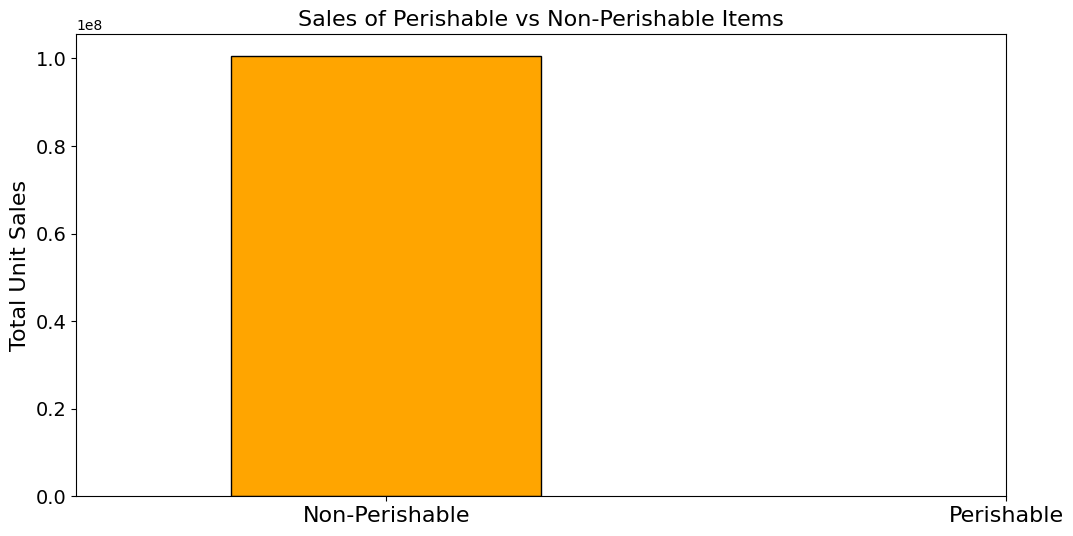

In [46]:
# Aggregating sales by perishable and non-perishable items
perishable_sales = df_train_items.groupby('perishable')['unit_sales'].sum()

# Plotting sales for perishable and non-perishable items
plt.figure(figsize=(12,6))
perishable_sales.plot(kind='bar', color=['orange', 'green'], edgecolor='black')
plt.title('Sales of Perishable vs Non-Perishable Items', fontsize=16)
plt.ylabel('Total Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(
    ticks=[0, 1],
    labels=['Non-Perishable', 'Perishable'],
    fontsize=16,
    rotation=0  # Keep x-axis labels horizontal
)
plt.yticks(fontsize=14)
plt.show()